# Load Shedding, Shifting and Elastic Demand

This notebook provides a simple illustration of how load shedding, load shifting, and elastic demand can be modeled in PyPSA. Through the example, we'll simulate a single day of electrical consumption in a solar-powered network, which could represent a household or a small community.



In [1]:
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Build example network

We'll start by constructing a minimal example network to demonstrate the demand modeling cases. The network consists of:

- a single bus which represents a network node, to which generation and loads are connected.
- an hourly time span of a single day, from 00:00 to 23:00.
- one PV (Photovoltaic) generator, generating only in the daytime.
- an electricity load profile (active), with peak load between 19:00 - 23:00.

In [2]:
# Create a new network
network = pypsa.Network()

# Add a bus
network.add("Bus", "My bus")

# Add the time frames (snapshots)
network.set_snapshots(pd.date_range("2023-01-01 00:00", "2023-01-01 23:00", freq="H"))

# Add solar generation profile (per unit of p_nom)
pv_pu = [
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.2,
    0.4,
    0.65,
    0.85,
    0.9,
    0.85,
    0.65,
    0.4,
    0.3,
    0.2,
    0.1,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
]

# Add solar generation to the bus
network.add(
    "Generator",
    "solar",
    bus="My bus",
    p_nom=0.4,
    p_max_pu=pv_pu,
    marginal_cost=0.01,
)

# Add a load electricity demand profile
low_load = pd.Series(0.05, index=range(8))  # constant base load
peak_load = pd.Series(0.2, index=range(5))  # assuming peak load between 18:00-23:00
baseload = pd.Series(0.15, index=range(11))  # constant base load
load = pd.concat([low_load, baseload, peak_load])
network.add("Load", "load", bus="My bus", p_set=load.values)

Plotting the minimal example network data, we can see that supply **cannot** equal demand at all time steps. This means that a stable grid operation is not possible.

Text(0, 0.5, 'Power (MW)')

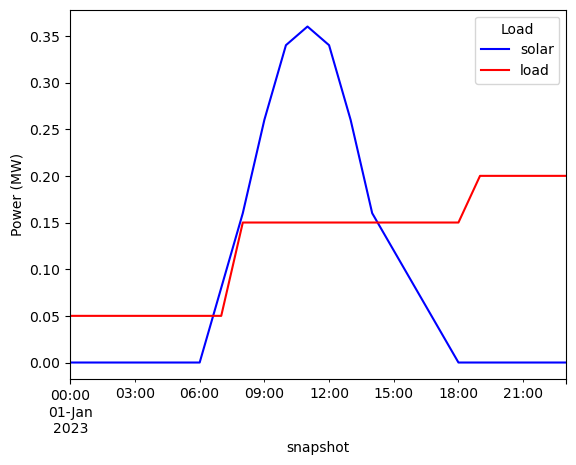

In [3]:
fig, ax = plt.subplots()

(network.generators_t.p_max_pu * network.generators.p_nom).plot(ax=ax,color='blue')
network.loads_t.p_set.plot(ax=ax,color='red')

ax.set_ylabel("Power (MW)")

Trying to optimize this network without any possibility of achieving the energy balance at every time step will lead to a infeasible optimization.

In [4]:
network.optimize()

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.04s
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: not available
Solver message: undefined



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-v9n8ju1w.lp --output /tmp/linopy-solve-v510bx11.sol
Reading problem data from '/tmp/linopy-problem-v9n8ju1w.lp'...
72 rows, 24 columns, 72 non-zeros
428 lines were read
GLPK Simplex Optimizer 5.0
72 rows, 24 columns, 72 non-zeros
Preprocessing...
PROBLEM HAS NO PRIMAL FEASIBLE SOLUTION
If you need actual output for non-optimal solution, use --nopresol
Time used:   0.0 secs
Memory used: 0.1 Mb (55757 bytes)
Writing basic solution to '/tmp/linopy-solve-v510bx11.sol'...


('warning', 'infeasible_or_unbounded')

## Load shedding

"Load shedding" in power networks often happens under extreme conditions, e.g. to prevent network faults. In models, we consider load shedding as extremely expensive and unconstrained generators that can practically decrease the demand to zero. Tip: Load shedding generators are often used to track-down infeasibilities from power shortages (as above) or too tight constraints.

In [5]:
# Add load shedding as generator
network.add(
    "Generator",
    "load shedding",
    bus="My bus",
    p_nom=50,
    p_max_pu=1.0,
    marginal_cost=1e2,  # 100 €/MWh
    p_nom_extendable=True,
)

After adding load shedding, the optimization will pass as the nodal energy balance is fulfilled

In [6]:
network.optimize()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 49 primals, 121 duals
Objective: 1.71e+02
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-3321hfzh.lp --output /tmp/linopy-solve-w0qr937m.sol
Reading problem data from '/tmp/linopy-problem-3321hfzh.lp'...
121 rows, 49 columns, 169 non-zeros
771 lines were read
GLPK Simplex Optimizer 5.0
121 rows, 49 columns, 169 non-zeros
Preprocessing...
~     0: obj =   1.710134000e+02  infeas =  0.000e+00
OPTIMAL SOLUTION FOUND BY LP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.1 Mb (89780 bytes)
Writing basic solution to '/tmp/linopy-solve-w0qr937m.sol'...


('ok', 'optimal')

Looking at the optimization results, the mismatch is exactly compensated by load shedding.

Text(0, 0.5, 'Power (MW)')

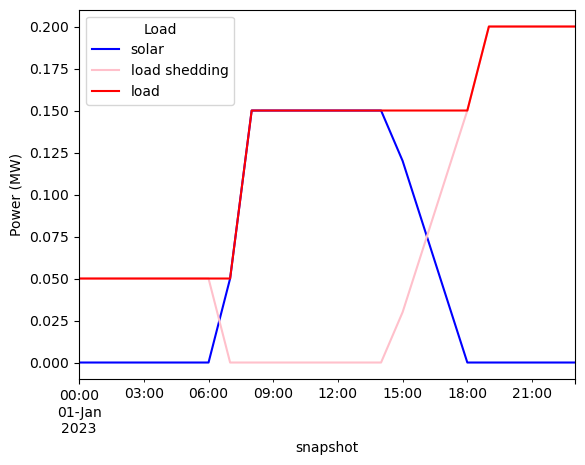

In [7]:
fig, ax = plt.subplots()

network.generators_t.p.plot(ax=ax, color=['blue','pink'])
network.loads_t.p.plot(ax=ax, color='red')

ax.set_ylabel("Power (MW)")

## Load shifting

"Load shifting" is often used to provide network benefits arising from demand side flexibility. A classic application in the electricity domain is **Electric Vehicle (EV)** battery. EVs can be scheduled to charge during off-peak hours when electricity demand is low, and electricity is cheaper. Furthermore, with Vehicle-to-Grid (V2G) capabilities, EVs can potentially supply power back to the grid during peak demand. In our model, we'll represent EV charging and potential discharging as storage units, which effectively act as energy time-shifters.

In [8]:
# add EV battery as storage unit
network.add(
    "StorageUnit",
    "EV battery",
    bus="My bus",
    p_nom=1, # positive to indicate that there is a device
    p_nom_extendable=True,
    standing_loss= 0.01,
    cyclic_state_of_charge= True,
    max_hours=10,
)

### Let's solve and plot load shifting and shedding 

In [9]:
network.optimize()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.15s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122 primals, 290 duals
Objective: 9.13e+01
Solver model: not available
Solver message: optimal



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp /tmp/linopy-problem-tk6ythxw.lp --output /tmp/linopy-solve-09s_l9i8.sol
Reading problem data from '/tmp/linopy-problem-tk6ythxw.lp'...
290 rows, 122 columns, 530 non-zeros
1882 lines were read
GLPK Simplex Optimizer 5.0
290 rows, 122 columns, 530 non-zeros
Preprocessing...
144 rows, 98 columns, 360 non-zeros
Scaling...
 A: min|aij| =  9.900e-01  max|aij| =  1.000e+01  ratio =  1.010e+01
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 144
      0: obj =   1.500155000e+02 inf =   1.710e+00 (16)
      7: obj =   1.710134000e+02 inf =   0.000e+00 (0)
*    50: obj =   9.134988476e+01 inf =   6.939e-17 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.3 Mb (269953 bytes)
Writing basic solution to '/tmp/linopy-solve-09s_l9i8.sol'...


('ok', 'optimal')

Text(0, 0.5, 'Power (MW)')

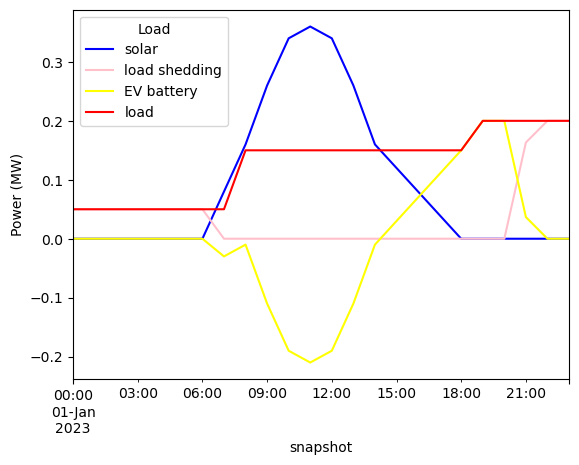

In [10]:
fig, ax = plt.subplots()

network.generators_t.p.plot(ax=ax, color=['blue','pink'])
network.storage_units_t.p.plot(ax=ax, color='yellow')
network.loads_t.p.plot(ax=ax, color='red')

ax.set_ylabel("Power (MW)")

We can observe from the least cost solution the following:
- The EV is charging when there is excess of solar generation (consuming power), and discharging when the solar generation is not sufficient for the  increasing the demand (supplying power)
- The EV helped in shifting the load from the peak hours to the off-peak hours in this scenario
- In the beginning and ending hours of the day, load shedding is applied since there is not enough storage or generation available

## Elastic Demand

Demand is slightly "elastic", meaning consumers would use less energy if its too expensive, or would use more energy if its low costs. Think about yourself. Would you consume less energy if it cost 5x more than today? The elasticity of demand is usually nonlinear and highly depended on individuals. If you are interested to read more into this, [Labandeira et al. (2017)](https://doi.org/10.1016/j.enpol.2017.01.002) surveys 428 papers that use various econometric techniques to evaluate energy demand elasticity to price.

We model eleastic demand by:
  - using a linear elasticity curve (price & demand relation)
  - iteration model runs with updated demands
  
Note. Demand is model input & the electricity price is the model output. See [here](https://github.com/PyPSA/PyPSA/issues/574) a nice illustration. The below elasticity curve is made up for demonstration purposes.

In [11]:
# assuming a linear demand response to price
def elasticity(system_cost_per_MWh):
    # y = mx + t
    # x = y - t / m
    return (system_cost_per_MWh - 120) / -300

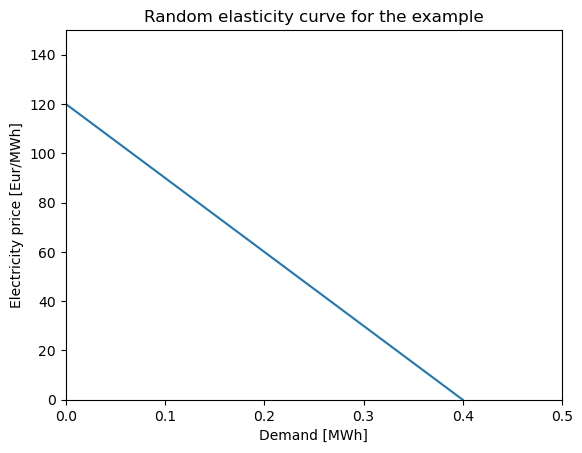

In [12]:
# Define a range of input values
x = np.arange(0, 300, 10)

# Calculate output values using the elasticity function
y = [elasticity(i) for i in x]

# Create the plot
plt.plot(y, x)
plt.xlabel("Demand [MWh]")
plt.ylabel("Electricity price [Eur/MWh]")
plt.title("Random elasticity curve for the example")
plt.xlim([0, 0.5])
plt.ylim([0, 150])
plt.show()

Using the same network as in the previous sections, we perform the iteration:
- add demand to network
- optimize network to get the system price
- update the demand by adding the system price to the elasticity curve

In [13]:
base_load = 0.2
all_networks = []
n = network

for _ in range(6):
    n = n.copy()
    load = pd.Series(
        base_load, index=range(24)
    )  # variable baseload based on base_load_values
    n.remove("Load", "load")
    n.add("Load", "load", bus="My bus", p_set=load.values)
    n.lopf()

    # Estimated price of the network in euros per MWh
    system_cost_per_MWh = (
        n.objective + n.objective_constant
    ) / n.loads_t.p.sum().sum()

    # assuming a linear demand response to price
    new_load = elasticity(system_cost_per_MWh)
    base_load = new_load

    all_networks.append(n)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.14s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.63e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.13s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.04e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.77e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.11s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.94e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.12s
INFO:pypsa.linopf:Solve linear problem using Glpk s

### Let's plot the elastic demand

In [14]:
### Demand and price values from the created networks
average_loads = []
prices = []
for n in all_networks:
    average_loads.append(n.loads_t.p.mean().sum())
    prices.append((n.objective + n.objective_constant) / n.loads_t.p.sum().sum())

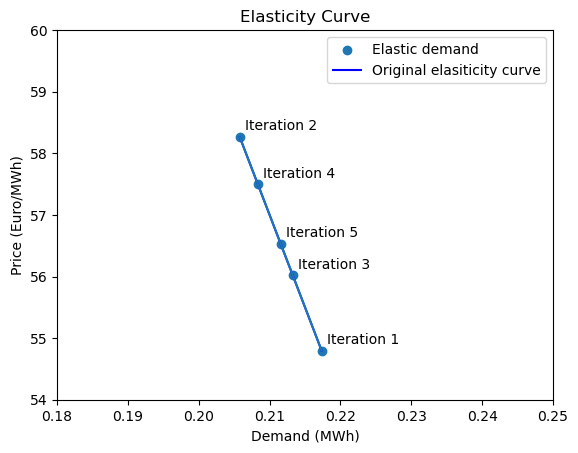

In [15]:
first_demand_iteration = average_loads[0]
updated_average_loads = average_loads[
    1:
]  # demand value in first iteration didn't have a price
updated_prices = prices[:-1]  # last price value wasn't used

# Scatter plot of the points
plt.scatter(updated_average_loads, updated_prices, label="Elastic demand")


# Add numbers to each point
for i, (x, y) in enumerate(zip(updated_average_loads, updated_prices)):
    plt.annotate(
        "Iteration " + str(i + 1),
        (x, y),
        textcoords="offset points",
        xytext=(30, 5),
        ha="center",
    )

# Fit a linear curve to the data
slope, intercept = np.polyfit(updated_average_loads, updated_prices, 1)

# Linear curve
x = np.linspace(min(updated_average_loads), max(updated_average_loads), 100)
y = slope * x + intercept
plt.plot(x, y, label=f"Original elasiticity curve", color="blue")

plt.xlabel("Demand (MWh)")
plt.ylabel("Price (Euro/MWh)")
plt.title("Elasticity Curve")
plt.legend(loc="upper right")
plt.xlim([0.18, 0.25])
plt.ylim([54, 60])
plt.plot(x, y)
plt.show()

We can observe from the elastic demand the following:
- Our initial average demand estimate of 0.2 MWh lead to a price resulting in more demand -> **iteration 1**.
- Using the new demand derieved from the elasticity curve and **iteration 1**, increased the average system price -> **iteration 2**
- ...
Luckily, after several iterations we observe that the results are **converging.**

**Note.** Here we solve the elastic demand as linear programming (LP) problem and several iterations. It is also possible to solve the problem with **one single** optimization run. PyPSA now supports this thanks to the QP programming capabilities added to Linopy v0.2. For more details, refer to the [Linopy release notes](https://github.com/PyPSA/linopy/releases).